## Import libraries and datasets

In [2]:
# Data manipulation
import numpy as np 
import pandas as pd   
import re

# Ignore warnings 
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Data visualization
import matplotlib
import seaborn as sns 
import matplotlib.pyplot as plt 
from wordcloud import WordCloud, STOPWORDS 

# Style
import matplotlib.style as style 
sns.set(font_scale=1.5)
style.use('seaborn-pastel')
sns.set(style="whitegrid")
sns.set_style("dark")

# Building recommender systems
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise import SVD
from surprise import KNNWithMeans
from surprise.model_selection import cross_validate
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

In [3]:
movies = pd.read_csv('movies.csv')
imdb_data = pd.read_csv('imdb_data.csv')
tags = pd.read_csv('tags.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
print(movies.shape)
print(imdb_data.shape)
print(tags.shape)
print(train.shape)
print(test.shape)


(62423, 3)
(27278, 6)
(1093360, 4)
(10000038, 4)
(5000019, 2)


## Let's have a look at the raw data

In [7]:
# Display the first 5 entries in each dataframe 
display(movies.head())
display(imdb_data.head())
display(tags.head())
display(train.head())

# Count the number of unique entries for features of interest
unique_movies = len(movies['movieId'].unique().tolist())
unique_tags = len(tags['tag'].unique().tolist())
unique_users = len(train['userId'].unique().tolist())
unique_directors = len(imdb_data['director'].unique().tolist())
unique_actors = len(imdb_data['title_cast'].unique().tolist())

# Create a dataframe to store the number of unique entries for features of interest
unique = pd.DataFrame({"movies": [unique_movies],
                       "tags" : [unique_tags],
                       "users": [unique_users],
                       "directors" : [unique_directors],
                       "actors" : [unique_actors]}, index=['unique_entries'])

print('number of unique entries for features of interest')
display(unique.transpose())

# Determine and display the min and max ratings received
min_rating = train.rating.min()
max_rating = train.rating.max()
print('Lowest rating: {}'.format(min_rating))
print('Highest rating: {}'.format(max_rating))

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


number of unique entries for features of interest


,unique_entries
movies,62423
tags,73051
users,162541
directors,11787
actors,17144


Lowest rating: 0.5
Highest rating: 5.0


## Preparing the data for better visualization

In [8]:
df = imdb_data[['movieId','title_cast','director', 'plot_keywords']]
df = df.merge(movies[['movieId', 'genres', 'title']], on='movieId', how='inner')
df.head()

,movieId,title_cast,director,plot_keywords,genres,title
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,toy|rivalry|cowboy|cgi animation,Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995)
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,board game|adventurer|fight|game,Adventure|Children|Fantasy,Jumanji (1995)
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,boat|lake|neighbor|rivalry,Comedy|Romance,Grumpier Old Men (1995)
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,black american|husband wife relationship|betra...,Comedy|Drama|Romance,Waiting to Exhale (1995)
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,fatherhood|doberman|dog|mansion,Comedy,Father of the Bride Part II (1995)


Plan of action:

1. Convert data types to strings
2. Remove the pipes between words
3. Limit the number of keywords and cast members per movie
4. Remove spaces between the names and surnames of actors/directors. This is so that names don't get confused or misinterpreted later on.

In [9]:
# Convert data types to strings for string handling
df['title_cast'] = df.title_cast.astype(str)
df['plot_keywords'] = df.plot_keywords.astype(str)
df['genres'] = df.genres.astype(str)
df['director'] = df.director.astype(str)

# Removing spaces between names
df['director'] = df['director'].apply(lambda x: "".join(x.lower() for x in x.split()))
df['title_cast'] = df['title_cast'].apply(lambda x: "".join(x.lower() for x in x.split()))

# Discarding the pipes between the actors' full names and getting only the first three names
df['title_cast'] = df['title_cast'].map(lambda x: x.split('|')[:3])

# Discarding the pipes between the plot keywords' and getting only the first five words
df['plot_keywords'] = df['plot_keywords'].map(lambda x: x.split('|')[:5])
df['plot_keywords'] = df['plot_keywords'].apply(lambda x: " ".join(x))

# Discarding the pipes between the genres 
df['genres'] = df['genres'].map(lambda x: x.lower().split('|'))
df['genres'] = df['genres'].apply(lambda x: " ".join(x))

df.head()

,movieId,title_cast,director,plot_keywords,genres,title
0,1,"[tomhanks, timallen, donrickles]",johnlasseter,toy rivalry cowboy cgi animation,adventure animation children comedy fantasy,Toy Story (1995)
1,2,"[robinwilliams, jonathanhyde, kirstendunst]",jonathanhensleigh,board game adventurer fight game,adventure children fantasy,Jumanji (1995)
2,3,"[waltermatthau, jacklemmon, sophialoren]",markstevenjohnson,boat lake neighbor rivalry,comedy romance,Grumpier Old Men (1995)
3,4,"[whitneyhouston, angelabassett, lorettadevine]",terrymcmillan,black american husband wife relationship betra...,comedy drama romance,Waiting to Exhale (1995)
4,5,"[stevemartin, dianekeaton, martinshort]",alberthackett,fatherhood doberman dog mansion,comedy,Father of the Bride Part II (1995)


## EDA phase

#### MoveLens rating distribution

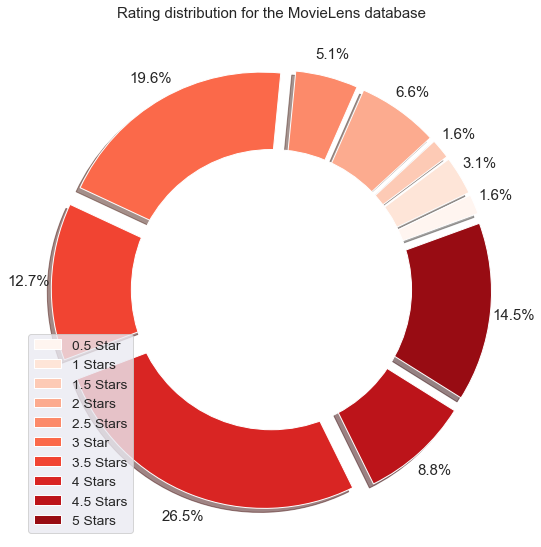

In [10]:
# Merge train with movies to join movie titles and ratings 
ratings = train.merge(movies, on='movieId', how='inner')
ratings.drop('timestamp', axis=1, inplace=True)

# Count how many ratings are in each category (1 star, 2 star, ect)
grouped = pd.DataFrame(ratings.groupby(['rating'])['title'].count())
grouped.rename(columns={'title':'rating_count'}, inplace=True)

# Creating plots 
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(122)
    
# Create colour palette
labels = ['0.5 Star', '1 Stars', '1.5 Stars', '2 Stars', '2.5 Stars', '3 Star', '3.5 Stars', '4 Stars', '4.5 Stars', '5 Stars']
theme = plt.get_cmap('Reds')
ax.set_prop_cycle("color", [theme(1. * i / len(labels))
                                 for i in range(len(labels))])
sns.set(font_scale=1.25)

# Create pie chart
pie = ax.pie(grouped['rating_count'],
                 autopct='%1.1f%%',
                 shadow=True,
                 startangle=20,
                 pctdistance=1.115,
                 explode=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1))
   
# Turn pie chart into a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Display donut plot with legend
plt.legend(pie[0], labels, loc="lower left")
ax.set_title('Rating distribution for the MovieLens database\n', fontsize=15)
plt.tight_layout()
plt.show()

Observations:

1. 4 Star ratings make up the largest portion of ratings in the MovieLens dataset, accounting for 26.5% of the overall ratings.
2. 5 star ratings make up 14.5% of the overall ratings (3rd largest portion)
3. 0.5 star ratings account for the smallest portion of the ratings at a mere 1.6%
4. Ratings between 2 and 0.5 stars account for 12.9%

#### Distribution of average ratings

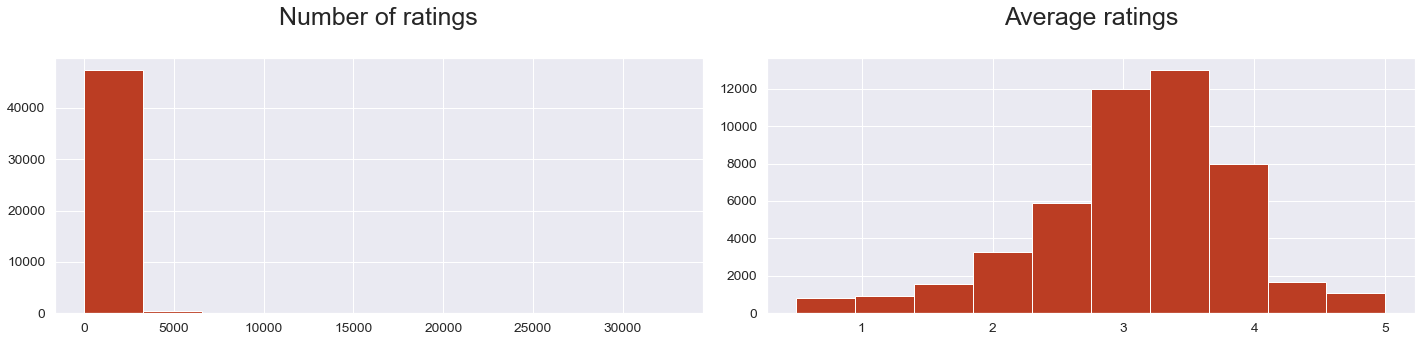

In [11]:
# Determine the average rating and number of ratings for each movie
ratings_mean_count = pd.DataFrame(ratings.groupby(['title'])[['rating']].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(ratings.groupby(['title'])['rating'].count())
ratings_mean_count['popularity'] = pd.DataFrame(ratings.groupby(['title'])['rating'].count()*ratings.groupby(['title'])['rating'].mean())

# Create a plot of the number of ratings 
f, axarr = plt.subplots(1,2, figsize=(20,5))
axarr[0].hist(ratings_mean_count['rating_counts'], bins=10, color='#bb3d23')
axarr[0].set_title('Number of ratings\n', fontsize=25)

# Create a plot showing the average ratings distribution 
axarr[1].hist(ratings_mean_count['rating'], bins=10, color='#bb3d23')
axarr[1].set_title('Average ratings\n', fontsize=25)

# Display both plots
plt.tight_layout()
plt.show()

Observations:

1. Most of the movies have received less than 2500 ratings. While the number of movies having more than 5000 ratings is very low.
2. The ratings follow a normal distribution that is slightly skewed to the right. It seems like users are generally generous with their ratings.
3. The mean rating is around 3.

#### Release year

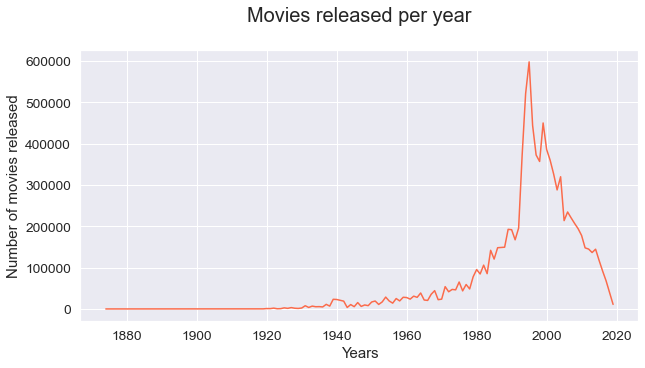

In [12]:
# Extract the release year fron the movie titles
ratings['release_year'] = ratings.title.map(lambda x: re.findall('\d\d\d\d', x))
ratings.release_year = ratings.release_year.apply(lambda x: np.nan if not x else int(x[-1]))
years =  pd.DataFrame(ratings.groupby(['release_year'])['title'].count())
years.rename(columns={'title':'movies released'}, inplace=True)

# Plot the number of movies released per year
plt.figure(figsize=(10,5))
plot = sns.lineplot(data=years, dashes=False, legend=False, palette='Reds_r')

# Add figure labels
plt.xlabel('Years', fontsize=15)
plt.ylabel('Number of movies released', fontsize=15)
plt.title('Movies released per year\n', fontsize=20)

plt.show() 

Observations:

1. This dataset contains movie ratings and movie specific data dating back 50 years.
2. There was a huge spike in movie production between 1990 and 2000 which has slowed down significantly in the last few years.

### Greatest hits: popular movies 

In [13]:
# Extract and display the 10 most popular films in the dataset 
ratings_mean_count = ratings_mean_count.sort_values(by='popularity', ascending=False).head(15)
ratings_mean_count.head(15)

,rating,rating_counts,popularity
title,,,
"Shawshank Redemption, The (1994)",4.417624,32831,145035.0
Pulp Fiction (1994),4.195097,31697,132972.0
Forrest Gump (1994),4.047216,32383,131061.0
"Silence of the Lambs, The (1991)",4.144172,29444,122021.0
"Matrix, The (1999)",4.154253,29014,120531.5
Star Wars: Episode IV - A New Hope (1977),4.111811,27560,113321.5
Schindler's List (1993),4.247625,24004,101960.0
Fight Club (1999),4.227906,23536,99508.0
Star Wars: Episode V - The Empire Strikes Back (1980),4.146236,22956,95181.0


Observations:

1. We see some really good movies like the Martrix, Star Wars and the Lord of the Rings in the top 15.
2. The above list supports our point that good movies normally receive both more and higher ratings
3. An interesting thing to note is that all the movies in the top 10 are older, with none of the movies more recent than 1999.
4. This just could be because these movies have been around longer and have been rated more as a result

### Rating distribution: Jurassic Park

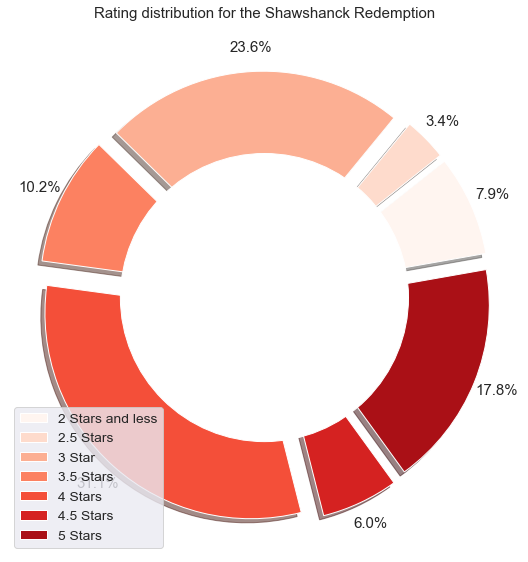

In [14]:
# Extract shawshank redemption ratings
top = ratings[ratings['title']=='Jurassic Park (1993)']

# Group all 2 star and lower ratings together
top.rating[top.rating == 0.5] = 2 
top.rating[top.rating == 1] = 2 
top.rating[top.rating == 1.5] = 2 

# Count how many ratings are in each category: 1 star, 2 star, ect
grouped = pd.DataFrame(top.groupby(['rating'])['title'].count())
grouped.rename(columns={'title':'rating_count'}, inplace=True)

# Create the figure
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(122)
    
# Create the colour palette
labels = ['2 Stars and less', '2.5 Stars', '3 Star', '3.5 Stars', '4 Stars', '4.5 Stars', '5 Stars']
theme = plt.get_cmap('Reds')
ax.set_prop_cycle("color", [theme(1. * i / len(labels))
                                 for i in range(len(labels))])
sns.set(font_scale=1.25)

# Create the pie chart
pie = ax.pie(grouped['rating_count'],
                 autopct='%1.1f%%',
                 #labels=labels, 
                 shadow=True,
                 startangle=10,
                 pctdistance=1.115,
                 explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1))
   
# Turn the pie chart into a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


# Display the donut chart with a legend
ax.set_title('Rating distribution for the Shawshanck Redemption\n', fontsize=15)
plt.legend(pie[0], labels, loc="lower left")
plt.tight_layout()
plt.show()

### Movie genres
How many different genres are represented in the dataset and how are they distributed?

In [ ]:
# def genre_count(input_df):
#     """
#     This function takes in the movies dataframe and cleans the genre column 
#     before extracting the unique genres together with their respective
#     frequencies in the dataset.
    
#     This information is then used to create a bar graph
#     showing how frequently each genre occurs in the dataset
    
#     Input: input df
#            datatype: DataFrame
           
#     Output: None
    
#     """   
#     df = input_df.copy()
#     dict_count = {}
    
#     # Extract the unique genres
#     all_genres = set(','.join([genres.replace('|',',').lower() for genres in df.genres]).split(','))
    
#     # Log the frequency of each genre 
#     for genre in all_genres:
#         dict_count[genre] = ','.join([genres.replace('|',',').lower() for genres in df.genres]).count(genre)
        
#     # Sort the genres according to their frequency
#     sorted_dict = sorted(dict_count.items(), key=lambda x: x[1],reverse=True)
#     genre, frequency = zip(*sorted_dict)
    
#     # Create bar plot 
#     fig = plt.figure(4, figsize=(15,10))
#     sns.barplot(x=frequency, y=list(genre), palette='Reds_r')
#     plt.title('Genre frequency\n',fontsize=25)
#     plt.xlabel('Genre_count', fontsize=15)
#     plt.ylabel('Genres', fontsize=15)
    
#     plt.show()
    
#     return

# genre_count(movies)

### Plot keywords
Lets have a look at the most frequently occuring plot keywords in the movielens dataset

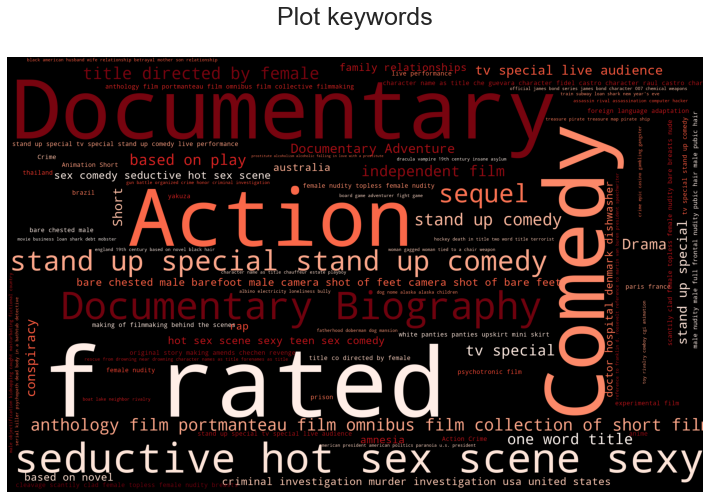

In [18]:
def wordcloud_generator(df, column):  
    """
    This function extracts all the unique keywords in a column
    and counts the number of times each keyword occurs in the column
    while ignoring words that are not meaningful.
    these keywords are then used to generate a word cloud 
    
    Input: df
           datatype: DataFrame
           column
           datatype: str
           
    Output: wordcloud
            Datatype: None
            
    """    
    keyword_counts = {}
    keyword_pair = []
    words = dict()
    
    # list of words that should be ignored
    ignore = ['nan', ' nan', 'nan ', 'seefullsummary', ' seefullsummary', 'seefullsummary ']
    
    # Extract the unique keywords 
    for keyword in [keyword for keyword in df[column] if keyword not in ignore]:
        if keyword in keyword_counts.keys():
            keyword_counts[keyword] += 1
        else:
            keyword_counts[keyword] = 1
     
    # Pair the keywords with their frequencies
    for word,word_freq in keyword_counts.items():
        keyword_pair.append((word,word_freq))
       
    # Sort the keywords accprding to their frequencies
    keyword_pair.sort(key = lambda x: x[1],reverse=True)
    
    # Make it wordcloud-ready
    for s in keyword_pair:
        words[s[0]] = s[1]
        
    # Create a wordcloud using the top 2000 keywords
    wordcloud = WordCloud(width=800, 
                          height=500, 
                          background_color='black', 
                          max_words=2000,
                          max_font_size=110,
                          scale=3,
                          random_state=0,
                          colormap='Reds').generate_from_frequencies(words)

    return wordcloud 

# Plot wordcloud
plot_keywords = wordcloud_generator(df, 'plot_keywords')
f = plt.figure(figsize=(20, 8)) 
plt.imshow(plot_keywords) 
plt.axis('off') 
plt.title('Plot keywords\n', fontsize=25)
plt.show()


### Directors
A film director controls a film's artistic and dramatic aspects and visualizes the screenplay while guiding the technical crew and actors in the fulfilment of that vision. The director has a key role in choosing the cast members, production design and all the creative aspects of filmmaking.

Let's have a closer look at the directors that appear frequently in our dataset. They must be doing something right.

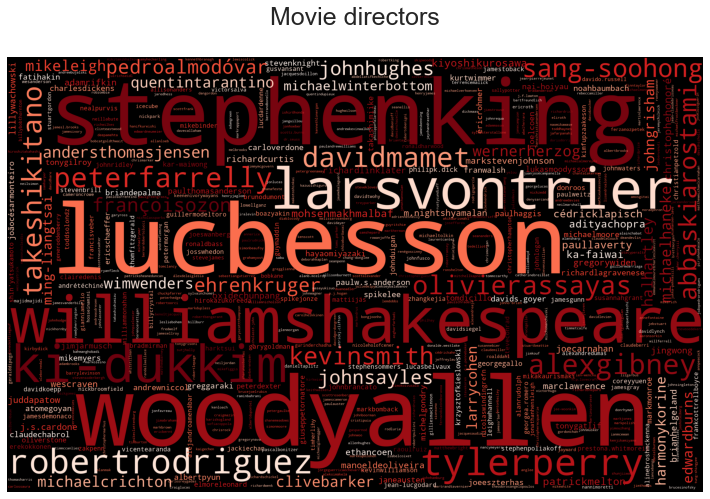

In [19]:
# Generate a WordCloud using the movie directors  
directors = wordcloud_generator(df, 'director')

# Plot the WordCloud 
f = plt.figure(figsize=(20, 8)) 
plt.imshow(directors) 
plt.axis('off') 
plt.title('Movie directors\n', fontsize=25)
plt.show()


### Actors
I'm sure we all have certain actors we feel can do no wrong and we just love watching. The film cast will definitely have an influence on how much you enjoy or how highly you rate a movie. I for one love everything Taraji P. Henson touches.

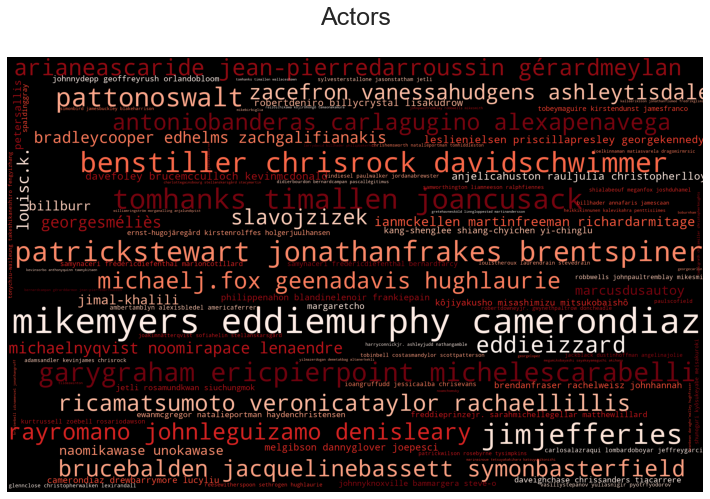

In [20]:
# Generate a wordcloud using the 2000 most frequently occuring actors' names in the dataset
df['title_cast'] = df['title_cast'].apply(lambda x: " ".join(x))
actors = wordcloud_generator(df, 'title_cast')

# plot the WordCloud                        
f = plt.figure(figsize=(20, 8)) 
plt.imshow(actors) 
plt.axis('off') 
plt.title('Actors\n', fontsize=25)
plt.show()

### Memory handling
Before we move on to building our recommender system it's good practice (and in this case, very necessary) to free up some memory by deleting the variables/dataframes we're done using

In [21]:
del top
del tags
del grouped
del ratings
del ratings_mean_count

#### Creating the corpus for each movie
We will be using the cast, director, plot keywords and genre as the metadata for our content based recommender system. These columns will be combined to form the corpus for each film which will then be used to determine the similarity between films.

In [22]:
# Creating an empty column and list to store the corpus for each movie
df['corpus'] = ''
corpus = []

# List of the columns we want to use to create our corpus 
columns = ['title_cast', 'director', 'plot_keywords', 'genres']

# For each movie, combine the contents of the selected columns to form it's unique corpus 
for i in range(0, len(df['movieId'])):
    words = ''
    for col in columns:
        words = words + df.iloc[i][col] + " "        
    corpus.append(words)

# Add the corpus information for each movie to the dataframe 
df['corpus'] = corpus
df.set_index('movieId', inplace=True)

# Drop the columns we don't need anymore to preserve memory
df.drop(columns=['title_cast', 'director', 'plot_keywords', 'genres'], inplace=True)

df.head()

,title,corpus
movieId,,
1,Toy Story (1995),tomhanks timallen donrickles johnlasseter toy ...
2,Jumanji (1995),robinwilliams jonathanhyde kirstendunst jonath...
3,Grumpier Old Men (1995),waltermatthau jacklemmon sophialoren marksteve...
4,Waiting to Exhale (1995),whitneyhouston angelabassett lorettadevine ter...
5,Father of the Bride Part II (1995),stevemartin dianekeaton martinshort alberthack...


### Count matrix
Our corpus will be converted into a bag of words using the count vectorizer.

The reason we chose to use the count vectorizer instead of tfidfvectorizer is because we don't want to penalize keywords, directors or actors that occur more frequently in the dataset. Having a high count across the dataset in this case does not mean that the word is less important. We also don't have any stopwords in the dataset that would need to be filtered out since we have already condensed our data.

In [23]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(df['corpus'])

### Cosine similarity matrix
Similarity is calculated as the cosine of the angle between the 2 vectors of the item vectors of A and B. The closer the vectors, the smaller the angle and larger the cosine similarity.



In [ ]:
# cos_sim = cosine_similarity(count_matrix, count_matrix)
# print(cos_sim.shape)
# cos_sim

In [25]:
# def get_topN_recommendations(title, n=10):
#     """
#     This function gets the top n recomended movies based on the 
#     title of the movie input by the user 
    
#     Input: title
#            Datatype: str
           
#            n (default = 10)
#            Datatype: int
#     """ 
#     # Create a a copy of the input dataframe where the index has been reset
#     df1 = df.reset_index()
    
#     # Extract the movie titles
#     titles = df1['title']
#     indices = pd.Series(df1.index, index=df['title'])
#     idx = indices[title]
    
#     # Get the similarity scores of the top n movies most similar to the user input
#     sim_scores = list(enumerate(cos_sim[idx]))
#     sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
#     sim_scores = sim_scores[1:n]
    
#     # Exctract the titles of the top n most similar movies  
#     movie_indices = [i[0] for i in sim_scores]
    
#     return titles.iloc[movie_indices]

# get_topN_recommendations('Ice Age (2002)').head(10)

NameError: name 'cos_sim' is not defined